In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
def convert_matrix(data,user,item,rating):
    matrix = data.pivot(index=user, columns=item, values=rating).as_matrix()
    return matrix   

In [3]:
def get_user_mean(matrix):
    return np.nanmean(matrix, axis = 1)

In [4]:
def centralize_matrix(matrix):
    user_mean = get_user_mean(matrix)
    centered_matrix = matrix - user_mean[:, np.newaxis]
    return centered_matrix

In [5]:
def cosine_matrix(matrix):
    where_are_NaNs = np.isnan(matrix)
    new_matrix = np.copy(matrix)
    new_matrix[where_are_NaNs] = 0
    squares = np.square(new_matrix)
    num = new_matrix.T.dot(new_matrix)
    one_matrix = np.copy(matrix)
    one_matrix[~np.isnan(one_matrix)] = 0
    one_matrix[np.isnan(one_matrix)] = 1
    one_matrix = 1 - one_matrix
    temp_matrix = squares.T.dot(one_matrix)
    den_matrix = temp_matrix.T * temp_matrix
    den = np.sqrt(den_matrix)
    output = np.divide(num,den)
    return output

In [6]:
def get_nearest_neighbors(matrix, k):
    t = np.argsort(-1 * matrix)
    return(t[:,1:1+k])

In [7]:
def predict(ratings,similarity,ranking,user,item):
    user_ratings_for_similar_items = ratings[user-1,ranking[item-1]]
    similarity_for_similar_items = similarity[item-1,ranking[item-1]]
    value = np.dot(user_ratings_for_similar_items, similarity_for_similar_items)/sum(np.absolute(similarity_for_similar_items))
    if np.isnan(value):
        value = np.nanmean(ratings[user-1])
        value = round(value * 2) / 2
    return value

In [8]:
def subset_of_original_data(data, Users = 10000, Movies = 100):
    movies = data.movieId.unique()
    movies_sub = movies[random.sample(list((range(0,len(movies)))),Movies)]
    print(len(movies_sub))
    print(movies_sub[0:5])
    subset_data = data[data.movieId.isin(movies_sub)]
    users = subset_data.userId.unique()
    users_sub =  users[random.sample(list((range(0,len(users)))),Users)]
    print(len(users_sub))
    print(users_sub[0:5])
    subset_data = subset_data[subset_data.userId.isin(users_sub)]
    subset_data.to_csv('Subset.csv')

In [9]:
def test_indices(matrix, split = 0.2):
    index = list(np.argwhere(~np.isnan(matrix)))
    test_indices = random.sample(index,int(0.2 * len(index)))
    train = np.copy(matrix)
    for idx in test_indices:
        train[idx[0],idx[1]] = np.nan
    return train,test_indices
    

In [10]:
def get_error(actual,predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.power(np.sum((actual - predicted ) * (actual - predicted)),0.5)

In [11]:
path = '../ml-latest-small/'
filename = 'ratings.csv'

In [12]:
data = pd.read_csv(path+filename)

In [13]:
subset_data = pd.read_csv('Subset.csv')

In [14]:
len(set(data.movieId))

9724

In [15]:
user_column_name = 'userId'
item_column_name = 'movieId'
rating_column_name = 'rating'

In [16]:
matrix = convert_matrix(data, user_column_name, item_column_name, rating_column_name)

/Users/ashwin/Documents/Columbia Courses/Personalization Theory/Project/personalization_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [17]:
matrix[2784,1]

IndexError: index 2784 is out of bounds for axis 0 with size 610

In [18]:
train,test = test_indices(matrix, split = 0.2)

In [19]:
split_size = [0.5, 0.2, 0.1]

In [20]:
neighbourhood_size = [1,2,3,5,10,20]

In [24]:
error_across_split_size = []
for split in split_size:
    train,test = test_indices(matrix, split)
    centered_matrix = centralize_matrix(train)
    output = cosine_matrix(centered_matrix)
    error = []
    for k in neighbourhood_size:
        nearest_items = get_nearest_neighbors(output,k)
        predicted_value = []
        actual_value = []
        for index in test:
            predicted_value += [predict(train,output,nearest_items, index[0]+1, index[1] + 1)]
            actual_value += [matrix[index[0], index[1]]]
        error += [get_error(actual_value, predicted_value)]
    error_across_split_size  += [error]

/Users/ashwin/Documents/Columbia Courses/Personalization Theory/Project/personalization_project/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [29]:
error_across_split_size
y = [[1,2,3],[4,5,6],[7,8,9]]

In [30]:
y

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

[1, 2, 3, 5, 10, 20]

In [31]:
error_across_split_size

[[137.4690874342301,
  135.2077105789459,
  134.89152020131667,
  134.78148982705304,
  134.7744782961522,
  134.77481218684744],
 [137.34900800515453,
  135.16425193075276,
  134.96182587844774,
  134.86667490525596,
  134.8492213548154,
  134.8471356759201],
 [139.35296911081585,
  136.33621125731784,
  136.02164860377516,
  136.01900602489346,
  135.95995734038755,
  135.95955280891445]]

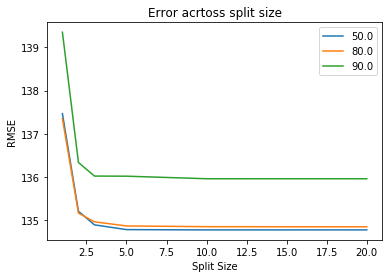

In [37]:
import matplotlib.pyplot as plt
x = neighbourhood_size
y = error_across_split_size
plt.xlabel("Split Size")
plt.ylabel("RMSE")
plt.title("Error across split size")
for i in range(len(y)):
    plt.plot(x,[pt for pt in y[i]], label = 100 * (1-split_size[i]))
plt.legend()
plt.show()

In [127]:
predict(train,output,nearest_items, index[0]+1, index[1] + 1)

[nan nan nan nan nan]
[1. 1. 1. 1. 1.]
3036 2


nan

In [128]:
nearest_items[index[1]-1]

array([40, 24, 19, 11,  8])

In [130]:
index[0]

3035

In [141]:
train[index[0]]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [140]:
matrix[index[0]]

array([nan, 0.5, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [139]:
matrix[index[0], index[1]]

0.5